In [0]:
# !wget http://www.brucehardie.com/datasets/CDNOW_master.zip
# !unzip CDNOW_master.zip
# !pip install lifetimes

### Loading Libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data,calculate_alive_path
from lifetimes.plotting import plot_period_transactions,plot_history_alive,plot_calibration_purchases_vs_holdout_purchases
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Load CDNOW Dataset

In [0]:
raw_data = pd.read_csv('CDNOW_master.txt','\s+',header=None,names=['Customer_ID','Transaction_Date','Quantity','Price'])
raw_data.head()

,Customer_ID,Transaction_Date,Quantity,Price
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [0]:
raw_data.shape

(69659, 4)

In [0]:
raw_data.describe()

,Customer_ID,Transaction_Date,Quantity,Price
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


### Format Purchase Date to Python DatetTime Object

In [0]:
raw_data['Transaction_Date'] = pd.to_datetime(raw_data['Transaction_Date'],format='%Y%m%d')
raw_data['Transaction_Date'].describe()

count                   69659
unique                    546
top       1997-02-24 00:00:00
freq                      504
first     1997-01-01 00:00:00
last      1998-06-30 00:00:00
Name: Transaction_Date, dtype: object

### Train & Test Data Split. Test on last three months of data

In [0]:
train_period =  raw_data['Transaction_Date'].max() + pd.DateOffset(months=-3)
rfm_data = calibration_and_holdout_data(raw_data,'Customer_ID','Transaction_Date',monetary_value_col='Price',freq="M", calibration_period_end=train_period,)

### RFM Dataset

In [0]:
rfm_data.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
Customer_ID,,,,,,,
1,0.0,0.000000,13.930471,0.00000,0.0,0.00,3
2,0.0,0.000000,13.930471,0.00000,0.0,0.00,3
3,3.0,9.987885,13.930471,39.57000,1.0,16.99,3
4,2.0,10.973531,13.930471,20.72000,0.0,0.00,3
5,8.0,11.992033,13.930471,42.78875,0.0,0.00,3


### Fit BG/NBD Model

In [0]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(rfm_data['frequency_cal'], rfm_data['recency_cal'], rfm_data['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 23570 subjects, a: 0.09, alpha: 4.31, b: 0.87, r: 0.43>

### Compare Actual Data with Data Simulated with BG/NBD Model Parameters

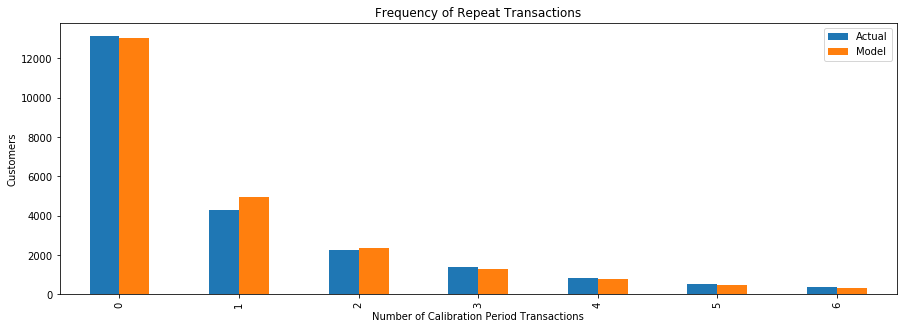

In [0]:
plot_period_transactions(bgf,figsize=(15,5))

### Holdout Prediction Model vs Actual

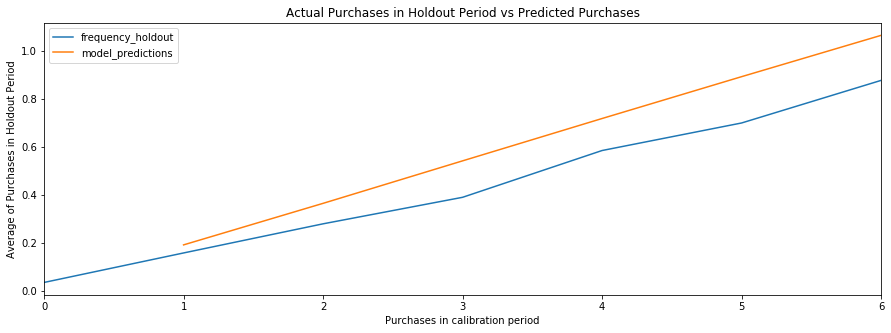

In [0]:
plot_calibration_purchases_vs_holdout_purchases(bgf, rfm_data,figsize=(15,5))

### Expected number of purchase for each customer in Holdout period

In [0]:
t = 3
rfm_data['Predict_Freq'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                   rfm_data['frequency_cal'], 
                                                                                   rfm_data['recency_cal'], 
                                                                                   rfm_data['T_cal'])
rfm_data['Predict_Freq'] =rfm_data['Predict_Freq'].fillna(0).round()
rfm_data.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,Predict_Freq
Customer_ID,,,,,,,,
1,0.0,0.000000,13.930471,0.00000,0.0,0.00,3,0.0
2,0.0,0.000000,13.930471,0.00000,0.0,0.00,3,0.0
3,3.0,9.987885,13.930471,39.57000,1.0,16.99,3,1.0
4,2.0,10.973531,13.930471,20.72000,0.0,0.00,3,0.0
5,8.0,11.992033,13.930471,42.78875,0.0,0.00,3,1.0


### Probability of alive for single customer

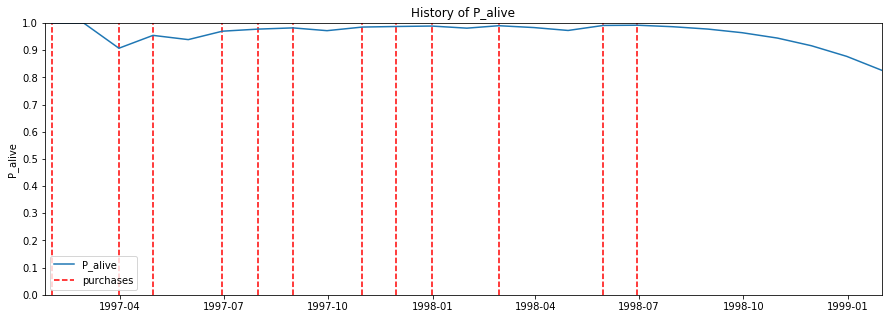

In [0]:
id = 6394
sp_trans = raw_data.loc[raw_data['Customer_ID'] == id]
plt.figure(figsize=(15,5))
plot_history_alive(bgf, 24, sp_trans, 'Transaction_Date',freq='M')

### compute Probability of alive for customer who were active in last three months of training period for next three months i.e. Holdout Period

In [0]:
active_period = train_period + pd.DateOffset(months=-3)
train_active = raw_data[(raw_data['Transaction_Date'] >= active_period) & (raw_data['Transaction_Date']<=train_period)]['Customer_ID']
active_customers_rfm = rfm_data.loc[rfm_data.index.isin(train_active),:].copy()
active_customers_rfm = active_customers_rfm[active_customers_rfm['recency_cal'] > 0].copy()

In [0]:
def get_alive_prob(row,model,time_period):
  alive_prob = model.conditional_probability_alive(row['frequency_cal'],row['recency_cal'],row['T_cal']+time_period)
  return alive_prob[0]

active_customers_rfm['alive_prob'] = active_customers_rfm.apply(get_alive_prob, model=bgf, time_period=12,axis=1)

In [0]:
active_customers_rfm.sample(5)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,Predict_Freq,alive_prob
Customer_ID,,,,,,,,,
21817,7.0,10.053595,11.992033,65.927143,0.0,0.000,3,1.0,0.332706
17259,4.0,11.992033,11.992033,76.380000,0.0,0.000,3,1.0,0.790207
22413,2.0,10.053595,11.992033,29.475000,0.0,0.000,3,0.0,0.801464
790,6.0,11.992033,13.930471,26.161667,3.0,20.684,3,1.0,0.553090
8464,3.0,12.911969,12.911969,49.606667,1.0,46.470,3,1.0,0.839938


In [0]:
repeated_customer = rfm_data[(rfm_data['frequency_cal'] > 0) & (rfm_data['monetary_value_cal'] > 0)].copy()
repeated_customer.shape

(10407, 8)

### Checking Assumptions of Gamma-Gamma Monetary Estimation Model

In [0]:
repeated_customer[['monetary_value_cal', 'frequency_cal']].corr()

,monetary_value_cal,frequency_cal
monetary_value_cal,1.000000,0.196816
frequency_cal,0.196816,1.000000


### Estimating Monetary value for repeated customers

In [0]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(repeated_customer['frequency_cal'],repeated_customer['monetary_value_cal'])

<lifetimes.GammaGammaFitter: fitted with 10407 subjects, p: 4.32, q: 3.34, v: 24.02>

In [0]:
repeated_customer['predicted_monetary_holdout'] = ggf.conditional_expected_average_profit(repeated_customer['Predict_Freq'],repeated_customer['monetary_value_cal'] )

### Estimating Customer Life Time Value

In [0]:
repeated_customer['cltv']= ggf.customer_lifetime_value(bgf,repeated_customer['frequency_cal'], repeated_customer['recency_cal'],
                                                      repeated_customer['T_cal'], repeated_customer['monetary_value_cal'],
                                                      time=3, discount_rate=0.01, freq = 'M')

### Sort Customers based on theri CLTV. Top 10 Customers

In [0]:
repeated_customer.sort_values(by='cltv',ascending=False).head(10)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,Predict_Freq,predicted_monetary_holdout,cltv
Customer_ID,,,,,,,,,,
7592,14.0,13.930471,13.930471,812.762143,3.0,69.803056,3,2.0,649.176707,1800.030523
14048,13.0,12.911969,12.911969,553.510769,3.0,45.815263,3,2.0,445.120644,1205.317457
7931,14.0,13.930471,13.930471,382.035000,3.0,126.305000,3,2.0,310.152525,848.105475
7983,12.0,12.911969,12.911969,400.796667,3.0,26.112045,3,2.0,324.919783,805.946074
22279,6.0,11.992033,11.992033,586.205000,0.0,0.000000,3,1.0,395.998784,613.580578
6569,13.0,13.930471,13.930471,294.653846,3.0,175.950000,3,2.0,241.375053,607.816748
13167,8.0,12.911969,12.911969,433.320000,2.0,111.583333,3,1.0,296.786064,577.313073
2664,12.0,13.930471,13.930471,290.356667,3.0,81.150000,3,2.0,237.992755,552.524847
22061,12.0,11.992033,11.992033,252.580000,3.0,23.084000,3,2.0,208.258841,537.916225
